In [1]:
import onnxruntime as ort
from onnx_inference import predict
from data_loader import data_loader
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import numpy as np
import matplotlib.pyplot as plt
from progressbar import ProgressBar

In [280]:
model_path = 'relu_models/model_2_relu_static_int8_pc_qop.onnx'
gpu_flag = False # Inference on GPU
usable_snr = False
best_snr = True

In [281]:
X_test, Y_test, Z_test = [ data_loader(usable_snr, best_snr)[key] for key in ('X_test','Y_test', 'Z_test')]

In [273]:
mods = ["OOK","4ASK","8ASK",
    "BPSK","QPSK","8PSK","16PSK","32PSK",
    "16APSK","32APSK","64APSK","128APSK",
    "16QAM","32QAM","64QAM","128QAM","256QAM",
    "AM-SSB-WC","AM-SSB-SC","AM-DSB-WC","AM-DSB-SC","FM",
    "GMSK","OQPSK","BFSK","4FSK","8FSK"]

num_classes = len(mods)

In [282]:
providers = ["CUDAExecutionProvider"] if gpu_flag else ["CPUExecutionProvider"]
session = ort.InferenceSession(model_path, providers=providers)

In [283]:
# Warm-up for inference device
tmp = predict(session, X_test[:10])

start_time = time.time()
y_pred = predict(session, X_test)
end_time = time.time()

y_pred = y_pred.reshape(np.shape(y_pred)[0], -1)  # general flattening
accuracy = accuracy_score(np.argmax(Y_test, axis=1), np.argmax(y_pred, axis=1))
total_time = end_time - start_time
total_samples = X_test.shape[0]
average_time = (total_time / total_samples) * 1e6  # µs

print(f"Total samples: {total_samples}")
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Total evaluation time: {total_time:.2f} s")
print(f"Average time per sample: {average_time:.2f} µs")

Total samples: 11060
Accuracy: 3.77%
Total evaluation time: 2.05 s
Average time per sample: 185.21 µs


In [166]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=[]):
    plt.figure(figsize = (15,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    label_len = np.shape(labels)[0]
    tick_marks = np.arange(label_len)
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()    
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

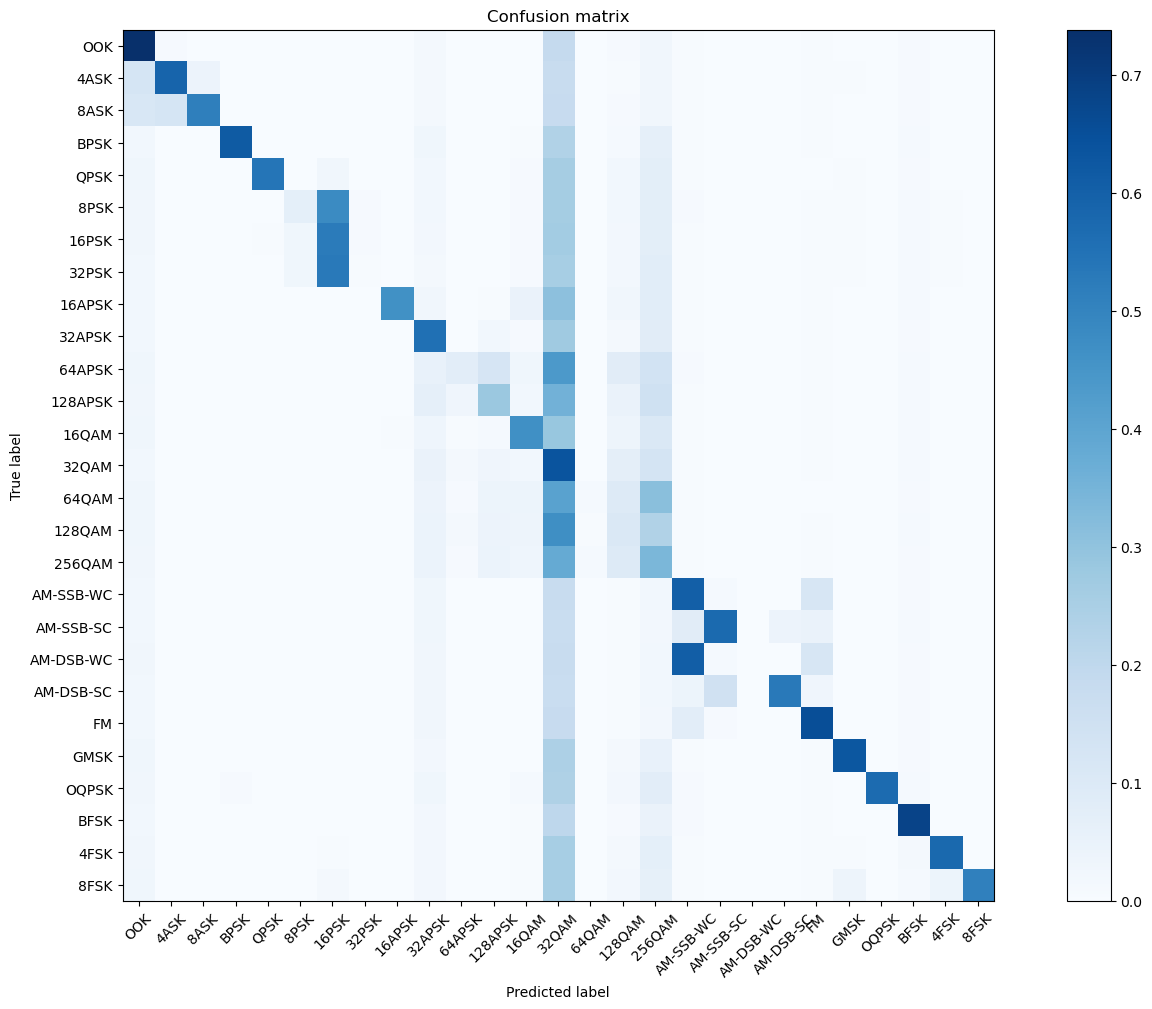

In [8]:
test_Y_hat = predict(model_path, X_test, Y_test, gpu_flag)
conf = np.zeros([num_classes,num_classes])
confnorm = np.zeros([num_classes,num_classes])
for i in range(0,X_test.shape[0]):
    j = list(Y_test[i,:]).index(1)
    k = int(np.argmax(test_Y_hat[i,:]))
    conf[j,k] = conf[j,k] + 1
for i in range(0,num_classes):
    confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])

plot_confusion_matrix(confnorm, labels=mods)

In [9]:
y_pred = predict(model_path, X_test, Y_test, gpu_flag)
y_pred = y_pred.reshape(np.shape(y_pred)[0], np.shape(y_pred)[2])
y_pred = np.argmax(y_pred, axis = 1)
y_actual = np.argmax(Y_test, axis = 1)
classificationreport_fp = classification_report(y_actual,y_pred, target_names=mods)
print(classificationreport_fp)

              precision    recall  f1-score   support

         OOK       0.47      0.74      0.57     10486
        4ASK       0.81      0.59      0.68     10721
        8ASK       0.92      0.51      0.66     10559
        BPSK       0.96      0.62      0.75     10512
        QPSK       0.98      0.54      0.70     10643
        8PSK       0.54      0.07      0.12     10804
       16PSK       0.33      0.52      0.41     10685
       32PSK       0.30      0.01      0.01     10688
      16APSK       0.96      0.46      0.62     10826
      32APSK       0.43      0.55      0.48     10664
      64APSK       0.47      0.08      0.13     10564
     128APSK       0.46      0.28      0.35     10730
       16QAM       0.62      0.47      0.53     10670
       32QAM       0.09      0.64      0.15     10633
       64QAM       0.36      0.01      0.02     10699
      128QAM       0.14      0.11      0.12     10673
      256QAM       0.14      0.34      0.20     10505
   AM-SSB-WC       0.40    

In [6]:
batchsize = 1024
progress = ProgressBar()
snrlist = np.unique(Z_test)
acc_snr_arr = []

# iterate over SNRs
for snr in progress(snrlist):
    acc_arr = []
    i_SNR = np.where(Z_test==snr)
    X_SNR = X_test[i_SNR[0],:,:]
    Y_SNR = Y_test[i_SNR[0],:]
    X_SNR_len = np.shape(X_SNR)[0]
    total_batches = int(X_SNR_len/batchsize)
    
    for i in (range(0, total_batches)):
        x_batch, y_batch = X_SNR[i*batchsize:i*batchsize+batchsize], Y_SNR[i*batchsize:i*batchsize+batchsize]
        
        # model prediction
        pred = predict(model_path, x_batch, y_batch, gpu_flag)
        
        #Prediction values are onehote, corresponding to indices representing different modulation types
        y_pred = pred.reshape(np.shape(pred)[0], np.shape(pred)[2])
        pred_ind = np.argmax(y_pred, axis = 1)
        expected_ind = np.argmax(y_batch, axis=1)
        matches  = sum(np.equal(pred_ind, expected_ind))
        acc      = matches/batchsize
        acc_arr.append(acc)

    # Average the per-batch accuracy values
    accuracy = np.mean(acc_arr)
    acc_snr_arr.append(accuracy)
    print("SNR: ", snr, "accuracy", accuracy)

  3% |#######                                                                                                                                                                                                     |

SNR:  -20 accuracy 0.03525390625


  7% |###############                                                                                                                                                                                             |

SNR:  -18 accuracy 0.03623046875


 11% |#######################                                                                                                                                                                                     |

SNR:  -16 accuracy 0.0369140625


 15% |###############################                                                                                                                                                                             |

SNR:  -14 accuracy 0.037109375


 19% |#######################################                                                                                                                                                                     |

SNR:  -12 accuracy 0.03779296875


 23% |###############################################                                                                                                                                                             |

SNR:  -10 accuracy 0.041796875


 26% |######################################################                                                                                                                                                      |

SNR:  -8 accuracy 0.0521484375


 30% |##############################################################                                                                                                                                              |

SNR:  -6 accuracy 0.0859375


 34% |######################################################################                                                                                                                                      |

SNR:  -4 accuracy 0.1466796875


 38% |##############################################################################                                                                                                                              |

SNR:  -2 accuracy 0.2083984375


 42% |######################################################################################                                                                                                                      |

SNR:  0 accuracy 0.3125


 46% |##############################################################################################                                                                                                              |

SNR:  2 accuracy 0.4578125


 50% |######################################################################################################                                                                                                      |

SNR:  4 accuracy 0.58525390625


 53% |#############################################################################################################                                                                                               |

SNR:  6 accuracy 0.65693359375


 57% |#####################################################################################################################                                                                                       |

SNR:  8 accuracy 0.70361328125


 61% |#############################################################################################################################                                                                               |

SNR:  10 accuracy 0.71337890625


 65% |#####################################################################################################################################                                                                       |

SNR:  12 accuracy 0.7220703125


 69% |#############################################################################################################################################                                                               |

SNR:  14 accuracy 0.72919921875


 73% |#####################################################################################################################################################                                                       |

SNR:  16 accuracy 0.720703125


 76% |############################################################################################################################################################                                                |

SNR:  18 accuracy 0.72568359375


 80% |####################################################################################################################################################################                                        |

SNR:  20 accuracy 0.7185546875


 84% |############################################################################################################################################################################                                |

SNR:  22 accuracy 0.721875


 88% |####################################################################################################################################################################################                        |

SNR:  24 accuracy 0.72685546875


 92% |############################################################################################################################################################################################                |

SNR:  26 accuracy 0.728515625


 96% |####################################################################################################################################################################################################        |

SNR:  28 accuracy 0.72578125


100% |############################################################################################################################################################################################################|

SNR:  30 accuracy 0.7255859375


<Figure size 100x100 with 0 Axes>

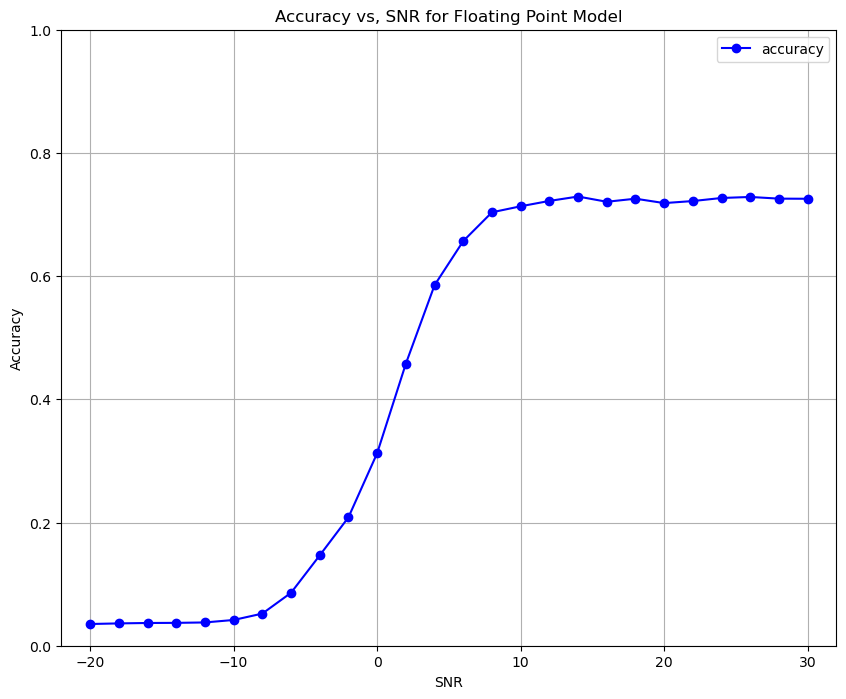

In [7]:
plt.figure(figsize=(1,1))
plt.show()
fig= plt.figure(figsize=(10,8))
plt.plot(snrlist, acc_snr_arr, 'bo-', label='accuracy')
plt.ylabel('Accuracy')
plt.xlabel('SNR')
plt.title("Accuracy vs, SNR for Floating Point Model")
plt.legend()
plt.axis([-22, 32, 0, 1.0])
plt.grid()